# Deep Learning

## Assignment 1

In [6]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import random
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

Download the training and data files for this assignment.

In [7]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = './data' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./data/notMNIST_large.tar.gz
Found and verified ./data/notMNIST_small.tar.gz


Unzip the files.

In [8]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for ./data/notMNIST_large. This may take a while. Please wait.
['./data/notMNIST_large/A', './data/notMNIST_large/B', './data/notMNIST_large/C', './data/notMNIST_large/D', './data/notMNIST_large/E', './data/notMNIST_large/F', './data/notMNIST_large/G', './data/notMNIST_large/H', './data/notMNIST_large/I', './data/notMNIST_large/J']
Extracting data for ./data/notMNIST_small. This may take a while. Please wait.
['./data/notMNIST_small/A', './data/notMNIST_small/B', './data/notMNIST_small/C', './data/notMNIST_small/D', './data/notMNIST_small/E', './data/notMNIST_small/F', './data/notMNIST_small/G', './data/notMNIST_small/H', './data/notMNIST_small/I', './data/notMNIST_small/J']


### Problem 1
Load the data in a more manageable format. We'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.
We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.
A few images might not be readable, we'll just skip them.

In [9]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling ./data/notMNIST_large/A.pickle.
./data/notMNIST_large/A
Could not read: ./data/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file './data/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: ./data/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file './data/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: ./data/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file './data/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.443121
Pickling ./data/notMNIST_large/B.pickle.
./data/notMNIST_large/B
Could not read: ./data/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file './data/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52911, 

### Problem 2
Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

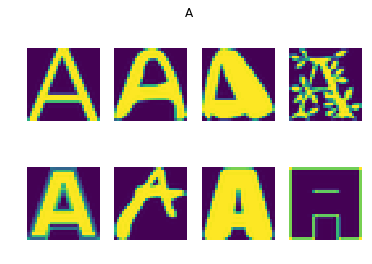

In [10]:
def disp_sample_pickles(data_folders):
    folder = random.sample(data_folders, 1)
    pickle_filename = ''.join(folder) + '.pickle'
    try:
        with open(pickle_filename, 'rb') as f:
            dataset = pickle.load(f)
    except Exception as e:
        print('Unable to read data from', pickle_filename, ':', e)
        return
    plt.suptitle(''.join(folder)[-1])
    for i, img in enumerate(random.sample(list(dataset), 8)):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.imshow(img)
        
disp_sample_pickles(train_folders)

### Problem 3
Another check: we expect the data to be balanced across classes. Verify that.

In [11]:
def disp_num_images(data_folders):
    for folder in data_folders:
        pickle_filename = ''.join(folder) + '.pickle'
        try:
            with open(pickle_filename, 'rb') as f:
                dataset = pickle.load(f)
        except Exception as e:
            print('Unable to read data from', pickle_filename, ':', e)
            return
        print('Number of images in', str(folder), ": ", len(dataset))

disp_num_images(train_folders)
disp_num_images(test_folders)

Number of images in ./data/notMNIST_large/A :  52909
Number of images in ./data/notMNIST_large/B :  52911
Number of images in ./data/notMNIST_large/C :  52912
Number of images in ./data/notMNIST_large/D :  52911
Number of images in ./data/notMNIST_large/E :  52912
Number of images in ./data/notMNIST_large/F :  52912
Number of images in ./data/notMNIST_large/G :  52912
Number of images in ./data/notMNIST_large/H :  52912
Number of images in ./data/notMNIST_large/I :  52912
Number of images in ./data/notMNIST_large/J :  52911
Number of images in ./data/notMNIST_small/A :  1872
Number of images in ./data/notMNIST_small/B :  1873
Number of images in ./data/notMNIST_small/C :  1873
Number of images in ./data/notMNIST_small/D :  1873
Number of images in ./data/notMNIST_small/E :  1873
Number of images in ./data/notMNIST_small/F :  1872
Number of images in ./data/notMNIST_small/G :  1872
Number of images in ./data/notMNIST_small/H :  1872
Number of images in ./data/notMNIST_small/I :  1872
Nu

There are some minor differences between different folders, but they are well balanced.

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [12]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class + tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels

train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [13]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

### Problem 4
Convince yourself that the data is still good after shuffling!

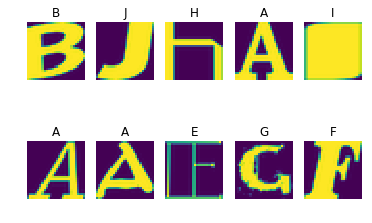

In [14]:
def disp_sample_dataset(dataset, label):
    items = random.sample(range(len(dataset)), 10)
    for i, sample in enumerate(items):
        plt.subplot(2, 5, i+1)
        plt.axis('off')
        plt.title(chr(label[sample] + 65))
        plt.imshow(dataset[sample])

disp_sample_dataset(train_dataset, train_labels)

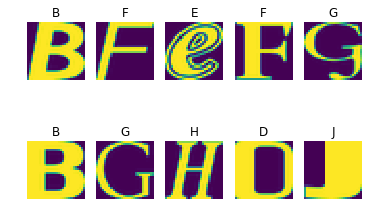

In [15]:
disp_sample_dataset(valid_dataset, valid_labels)

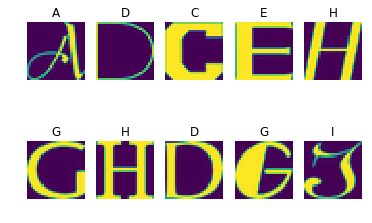

In [16]:
disp_sample_dataset(test_dataset, test_labels)

Finally, let's save the data for later reuse:

In [17]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [18]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


In [36]:
def extract_overlap(dataset_1, dataset_2):
  overlap = {}
  for i, img_1 in enumerate(dataset_1):
    for j, img_2 in enumerate(dataset_2):     
      if np.array_equal(img_1, img_2):
        if not i in overlap.keys():
          overlap[i] = []
        overlap[i].append(j)
  return overlap

%time overlap_test_train = extract_overlap(test_dataset[:200], train_dataset)

Wall time: 3min 25s


In [37]:
print('Number of overlaps:', len(overlap_test_train.keys()))

Number of overlaps: 24


### Problem 6
Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

------
I have never used TensorFlow before.

In [47]:
regr = LogisticRegression()
test_shape0, test_shape1, test_shape2 = test_dataset.shape
x_test = test_dataset.reshape(test_shape0, test_shape1 * test_shape2)
y_test = test_labels

In [55]:
sample_size = 50
x_train = train_dataset[:sample_size].reshape(sample_size, 28 * 28)
y_train = train_labels[:sample_size]
%time regr.fit(x_train, y_train)
regr.score(x_test, y_test)

Wall time: 75 ms


0.50900000000000001

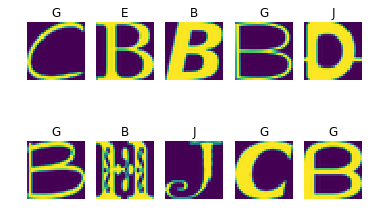

In [56]:
pred_labels = regr.predict(x_test)
disp_sample_dataset(test_dataset, pred_labels)

In [57]:
sample_size = 100
x_train = train_dataset[:sample_size].reshape(sample_size, 28 * 28)
y_train = train_labels[:sample_size]
%time regr.fit(x_train, y_train)
regr.score(x_test, y_test)

Wall time: 176 ms


0.6966

In [62]:
sample_size = 1000
x_train = train_dataset[:sample_size].reshape(sample_size, 28 * 28)
y_train = train_labels[:sample_size]
%time regr.fit(x_train, y_train)
regr.score(x_test, y_test)

Wall time: 3.37 s


0.83330000000000004

In [63]:
x_valid = valid_dataset[:sample_size].reshape(sample_size, 28 * 28)
y_valid = valid_labels[:sample_size]
regr.score(x_valid, y_valid)

0.73599999999999999

In [64]:
sample_size = 5000
x_train = train_dataset[:sample_size].reshape(sample_size, 28 * 28)
y_train = train_labels[:sample_size]
%time regr.fit(x_train, y_train)
regr.score(x_test, y_test)

Wall time: 29.9 s


0.85099999999999998

In [65]:
regr2 = LogisticRegression(solver='sag')
x_train = train_dataset.reshape(len(train_dataset), 28 * 28)
y_train = train_labels
%time regr2.fit(x_train, y_train)
regr2.score(x_test, y_test)

Wall time: 17min 7s


0.85099999999999998

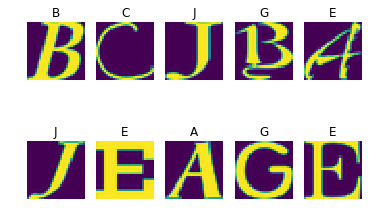

In [66]:
pred_labels = regr2.predict(x_test)
disp_sample_dataset(test_dataset, pred_labels)

(200000L, 784L)
